# Курс ["Алгоритмы анализа данных"](https://gb.ru/lessons/177362)

# Урок 4. Алгоритм построения дерева решений

In [ ]:
import numpy as np
import pandas as pd
import inspect
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn import model_selection

In [ ]:
 %matplotlib inline

In [ ]:
classification_data, classification_labels = datasets.make_classification(n_features = 5, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

In [ ]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data,
                                                                                     classification_labels,
                                                                                     test_size=0.3,
                                                                                     random_state=1)

## Задание 1.

### В коде из методички реализуйте один или несколько критериев останова (глубина дерева, количество листьев и т.д.).

In [ ]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        self.max_leaf = 5 # максимальное количество листьев в узле
        self.leafs = self.count_leafs() # количество листьев в узле
    
    def count_leafs(self):
        branches = [self.true_branch, self.false_branch]
        leafs = 0
        for branch in branches:
          if type(branch) is Leaf:
            leafs += 1
          elif type(branch) is Node:
            leafs += branch.leafs
        return leafs

In [ ]:
# И класс терминального узла (листа)
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction

In [ ]:
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2 
    return impurity

In [ ]:
def quality(left_labels, right_labels, current_gini):
    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [ ]:
def split(data, labels, index, t):
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
    return true_data, false_data, true_labels, false_labels

In [ ]:
#  обозначим минимальное количество объектов в узле 
def find_best_split(data, labels, n_features=None, min_leaf=5):
    
    current_gini = gini(labels)
    best_quality = 0
    best_t = None
    best_index = None
    
    if n_features is None:
        n_features = data.shape[1] #######!!!!!! вынести в атрибуты
    
    for index in range(n_features):
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [ ]:
# Построение дерева с помощью рекурсивной функции
def build_tree(data, labels, max_leaf=5, n_features=None): ###!!!!!!!!! вынести в атрибуты

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0 or max_leaf == 1:
        return Leaf(data, labels)
    
    node = Node(index, t, None, None)
    node.max_leaf = max_leaf
    
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, max_leaf=node.max_leaf-1)
    false_branch = build_tree(false_data, false_labels, max_leaf=node.max_leaf-node.leafs)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [ ]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [ ]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [ ]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [ ]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [ ]:
# Построим дерево по обучающей выборке, где i - максимальное количество объектов в листе:
accurancy_df = pd.DataFrame(columns=['max leafs', 'features used', 'train accuracy', 'test accuracy'])
for i in range (1,10):
    for j in range (1,10):
        my_tree = build_tree(train_data, train_labels, max_leaf=i, n_features=j)
        train_answers = predict(train_data, my_tree)
        test_answers = predict(test_data, my_tree)
        train_accuracy = accuracy_metric(train_labels, train_answers)
        test_accuracy = accuracy_metric(test_labels, test_answers)
        accurancy_df = accurancy_df.append(pd.Series([i, j, train_accuracy, test_accuracy], 
                                            index=accurancy_df.columns), 
                                            ignore_index=True)
        


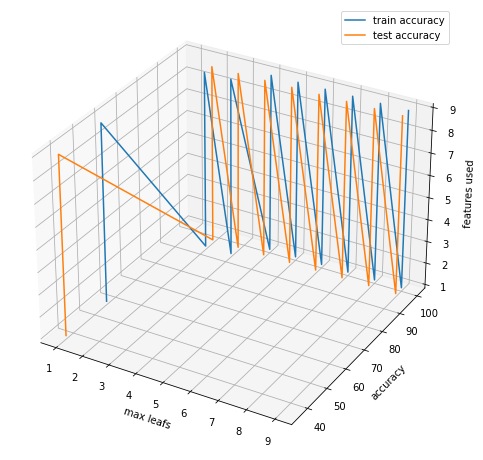

In [ ]:
ax = plt.figure(figsize=(8, 10)).add_subplot(projection='3d')
ax.plot(accurancy_df['max leafs'],
        accurancy_df['train accuracy'],
        accurancy_df['features used'],  
        label='train accuracy')

ax.plot(accurancy_df['max leafs'],
        accurancy_df['test accuracy'],
        accurancy_df['features used'],  
        label='test accuracy')

ax.set_xlabel('max leafs')
ax.set_ylabel('accuracy')
ax.set_zlabel('features used')

ax.legend()
plt.show()

<AxesSubplot:>

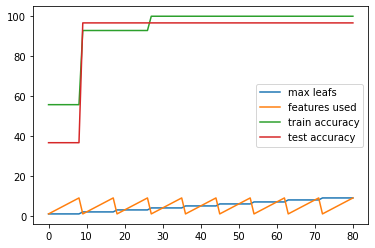

In [ ]:
accurancy_df.plot()

In [ ]:
 accurancy_df.loc[
                    (accurancy_df['test accuracy'] == accurancy_df['test accuracy'].max())
                    & (accurancy_df['features used'] == accurancy_df['features used'].min())
                    #& (accurancy_df['max leafs'] == accurancy_df['max leafs'].min())
                ].sort_values(by=['max leafs','features used'])

,max leafs,features used,train accuracy,test accuracy
9,2.0,1.0,92.857143,96.666667
18,3.0,1.0,92.857143,96.666667
27,4.0,1.0,100.000000,96.666667
36,5.0,1.0,100.000000,96.666667
45,6.0,1.0,100.000000,96.666667
54,7.0,1.0,100.000000,96.666667
63,8.0,1.0,100.000000,96.666667
72,9.0,1.0,100.000000,96.666667


Наиболее эфективными оказались деревья с двумя листами и одной фичей. 

## Задание 2.
### Для задачи классификации обучите дерево решений с использованием критериев разбиения Джини и Энтропия. Сравните качество классификации, сделайте выводы.

In [ ]:
my_tree_gini = build_tree(train_data, train_labels)
train_answers_gini = predict(train_data, my_tree_gini)
test_answers_gini = predict(test_data, my_tree_gini)
train_accuracy_gini = accuracy_metric(train_labels, train_answers_gini)
test_accuracy_gini = accuracy_metric(test_labels, test_answers_gini)

In [ ]:
def calc_entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    #  расчет критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p * np.log2(p)
        
    return impurity

In [ ]:
def quality(left_labels, right_labels, current_entropy):
    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    return current_entropy - p * calc_entropy(left_labels) - (1 - p) * calc_entropy(right_labels)

In [ ]:
#  переназначим критерий  
def find_best_split(data, labels, n_features=None, min_leaf=5):
    
    current_entropy = calc_entropy(labels)
    best_quality = 0
    best_t = None
    best_index = None
    
    if n_features is None:
        n_features = data.shape[1] #######!!!!!! вынести в атрибуты
    
    for index in range(n_features):
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_entropy)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [ ]:
my_tree_entropy = build_tree(train_data, train_labels)
train_answers_entropy = predict(train_data, my_tree_entropy)
test_answers_entropy = predict(test_data, my_tree_entropy)
train_accuracy_entropy = accuracy_metric(train_labels, train_answers_entropy)
test_accuracy_entropy = accuracy_metric(test_labels, test_answers_entropy)

In [ ]:
gini(train_labels), calc_entropy(train_labels)

(0.493469387755102, 0.9905577004075261)

In [ ]:
train_accuracy_gini, test_accuracy_gini

(100.0, 96.66666666666667)

In [ ]:
train_accuracy_entropy, test_accuracy_entropy

(100.0, 96.66666666666667)

Не вижу разницы в использовании критериев..

## Задание 3. (*) 
### Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, а критерий Джини на дисперсию значений.

In [ ]:
# Класс узла для регрессии

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.labels.mean()

In [ ]:
# Расчет критерия Джини

def gini(labels):
    return labels.var()

In [ ]:
# сгенерируем данные
regression_data, regression_labels = datasets.make_regression(n_features = 2, n_informative = 2, 
                                                      random_state=42)

In [ ]:
# Разобьем выборку на обучающую и тестовую
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(regression_data, regression_labels,
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [ ]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, max_leaf=5)

In [ ]:
my_tree.leafs

8